In [1]:
%load_ext autoreload
%autoreload 2

# NLP Twitter Sentiment Analysis Project
<font size="4"> Author: Jeffrey Hanif Watson </font>

## Project Goals & Overview:
Develop and train a natural language processing model to classify the sentiment of tweets.

## Business Understanding:
Companies can benefit from understanding how consumers perceive and feel about their brands and products, and sentiment analysis of text data from twitter can help provide this knowledge in a timely manner.

## Data Understanding:
The data for this project consists of a csv file containing 9,093 rows of text data (tweets, brand/product ids, sentiments labels) originally sourced from [Twitter](https://twitter.com/?lang=en) and collected into the [crowdflower/brands-and-product-emotions](https://data.world/crowdflower/brands-and-product-emotions). From the overwhelming amount of SXSW hashtags, and numerous references to the iPad 2 (which was released on March 2nd, 2011), it appears that the data was collected during the 2011 South by Southwest festival (which ran from March 11th to March 20th).

## Package Imports & Setup 
Importing the required packages, setting the project path and notebook styling.

In [2]:
# imports
import os, sys, string, re, itertools, more_itertools, random
from more_itertools import take

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

import pandas as pd
import numpy as np

import nltk

from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.base import clone
# from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (StratifiedKFold, train_test_split,
                                     cross_val_score, GridSearchCV)
from sklearn.feature_extraction.text import (CountVectorizer, TfidfVectorizer,
                                             TfidfTransformer)
from sklearn.metrics import (f1_score, recall_score, precision_score,
                             make_scorer, plot_confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline

import matplotlib.pyplot as plt
# from matplotlib import cm
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

from src import visualizations as vz
from src import functions as fn
from src import classes as cl                                     

# # updates for nltk helper packages if needed
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
                                     
# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')
pd.options.display.max_rows = 300

## Modeling I: (Exploring the Data)

## `dir` Check
Checking where we are before setting the path.

In [3]:
!pwd

/Users/dsbox/Documents/Flatiron/p_4_project/nlp_sentiment_project/notebooks/exploratory


## Importing Data:
Setting path to the data, creating data frame, and checking first five rows.

In [4]:
path = path = os.path.join(gparent, 'data/processed',\
                           'modeling_binary.csv')
df = pd.read_csv(path, encoding='unicode_escape')
df.head()

,emotion,stems,lemmas,tweet,brand_product,hashtags
0,0,3g iphon 3 hr tweet rise austin dead need upgr...,3g iphone 3 hr tweeting rise austin dead need ...,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,"['#RISE_Austin', '#SXSW']"
1,1,know awesom ipad iphon app like appreci design...,know awesome ipad iphone app likely appreciate...,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,['#SXSW']
2,1,wait ipad 2 also sale sxsw,wait ipad 2 also sale sxsw,@swonderlin Can not wait for #iPad 2 also. The...,iPad,"['#iPad', '#SXSW']"
3,0,hope year festiv crashi year iphon app sxsw,hope year festival crashy year iphone app sxsw,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,['#sxsw']
4,1,great stuff fri sxsw marissa mayer googl tim r...,great stuff fri sxsw marissa mayer google tim ...,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,['#SXSW']


## Checking the DF Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3537 entries, 0 to 3536
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion        3537 non-null   int64 
 1   stems          3537 non-null   object
 2   lemmas         3537 non-null   object
 3   tweet          3537 non-null   object
 4   brand_product  3180 non-null   object
 5   hashtags       3531 non-null   object
dtypes: int64(1), object(5)
memory usage: 165.9+ KB


## Splitting Initial `data` & `target` Series
<font size="4">`emotion` column values = {0: 'negative', 1: 'positive'}</font>

In [6]:
data_lemms = df.lemmas
data_stems = df.stems
target = df['emotion']

In [7]:
data_lemms.isna().sum()
data_stems.isna().sum()

0

In [8]:
target.isna().sum()

0

In [9]:
# checking lengths
idx = [data_lemms, data_stems, target]
for i in idx:
    print(f'{len(i)}')

3537
3537
3537


## Creating Modeling & Holdout Data

We are going to focus on modeling with the lemmatized, but we'll prepare a train-validation-test split for the stemmed data just in case. 

In [10]:
# Creating data & target
X_lem = data_lemms
y_lem = target

In [11]:
# checking lengths
print(len(X_lem))
print(len(y_lem))

3537
3537


<font size="4"> Creating holdout data for testing. X_lem_testing and y_lem_testing will be withheld until the final model is chosen and then used gauge the model's performance on out of sample data. The test set size is 20% of the original lemmatized data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and testing sets. </font>

In [12]:
X_lem_training, X_lem_testing, y_lem_training, y_lem_testing = fn.splitter(X_lem, y_lem)

In [13]:
# checking sizes
print(len(X_lem_training))
print(len(y_lem_training))
print(len(X_lem_testing))
print(len(y_lem_testing))

2652
2652
885
885


<font size="4">Splitting the X_lem_training data to create training and validation sets to train the models. The validation set size is 20% of the X_lem_training data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and validation sets.</font>

In [14]:
X_lem_train, X_lem_val, y_lem_train, y_lem_val = fn.splitter(X_lem_training, y_lem_training)

In [15]:
# checking sizes
print(len(X_lem_train))
print(len(y_lem_train))
print(len(X_lem_val))
print(len(y_lem_val))

1989
1989
663
663


#### Stemmed Data

In [16]:
X_stem = data_stems
y_stem = target

In [17]:
# checking lengths
print(len(X_stem))
print(len(y_stem))

3537
3537


<font size="4"> Creating holdout data for testing. X_stem_testing and y_stem_testing will be withheld until the final model is chosen and then used gauge the model's performance on out of sample data. The test set size is 20% of the original stemmed data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and testing sets. </font>

In [18]:
X_stem_training, X_stem_testing, y_stem_training, y_stem_testing = fn.splitter(X_stem, y_stem)

In [19]:
# checking sizes
print(len(X_stem_training))
print(len(y_stem_training))
print(len(X_stem_testing))
print(len(y_stem_testing))

2652
2652
885
885


<font size="4">Splitting the X_stem_training data to create training and validation sets to train the models. The validation set size is 20% of the X_stem_training data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and validation sets.</font>

In [20]:
X_stem_train, X_stem_val, y_stem_train, y_stem_val = fn.splitter(X_stem_training, y_stem_training)

In [21]:
# checking sizes
print(len(X_stem_train))
print(len(y_stem_train))
print(len(X_stem_val))
print(len(y_stem_val))

1989
1989
663
663


In [22]:
len(X_stem) == len(y_stem)

True

## EDA & Corpus Statistics 

## Splitting Emotions

In [23]:
positive = df[df['emotion']==1]
negative = df[df['emotion']==0]

## Emotion Vocabularies

#### Lemma Vocabulary

In [24]:
vocab_lem_pos = fn.vocabulary(positive.lemmas)
len(vocab_lem_pos)

4624

<font size="4"> There are 4,624 unique tokens in the positve lemmatized tweets.</font>

In [25]:
pos_words = fn.words(positive.lemmas)
fn.word_frequencies(pos_words, 25)

Word 			Frequency

sxsw      		0.0973    
ipad      		0.0318    
apple     		0.0289    
google    		0.0228    
store     		0.0174    
iphone    		0.017     
2         		0.016     
app       		0.0124    
new       		0.0112    
austin    		0.0092    
pop       		0.0066    
ipad2     		0.0065    
android   		0.0064    
get       		0.0056    
launch    		0.0054    
party     		0.0047    
one       		0.0047    
line      		0.0045    
great     		0.0043    
time      		0.0042    
via       		0.0041    
day       		0.0039    
free      		0.0038    
social    		0.0038    
circle    		0.0038    


<font size="4">We can see that the top word (sxsw with frequency 9.73%) is three times as likely as the next most frequent word, and after the 8th most frequent word the frequencies drop below 1%.</font> 

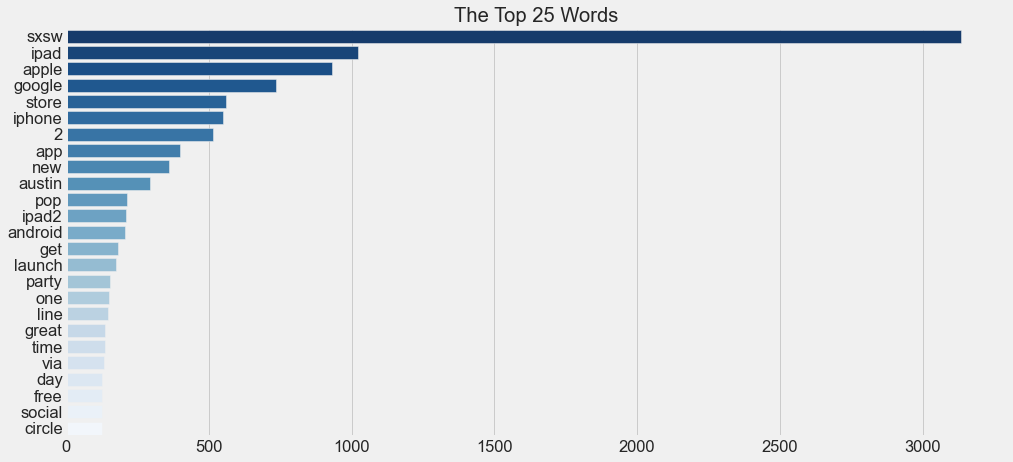

In [26]:
vz.top_word_list(pos_words, 25)

<font size="4">The plot the top 25 words confirms that sxsw is by far the most frequent and the frequencies drop rapidly after the first few words.</font>

In [27]:
vocab_lem_neg = fn.vocabulary(negative.lemmas)
len(vocab_lem_neg)

1920

<font size="4"> There are 1,920 unique tokens in the negative lemmatized tweets.</font>

In [28]:
neg_words = fn.words(negative.lemmas)
fn.word_frequencies(neg_words, 25)

Word 			Frequency

sxsw      		0.0923    
ipad      		0.0308    
iphone    		0.0256    
google    		0.0238    
apple     		0.0194    
2         		0.0117    
app       		0.0095    
store     		0.0074    
new       		0.0068    
like      		0.0068    
circle    		0.0058    
need      		0.0055    
social    		0.0049    
apps      		0.0047    
design    		0.0046    
people    		0.0046    
austin    		0.0044    
get       		0.0039    
android   		0.0038    
one       		0.0036    
think     		0.0036    
time      		0.0036    
line      		0.0035    
launch    		0.0035    
day       		0.0035    


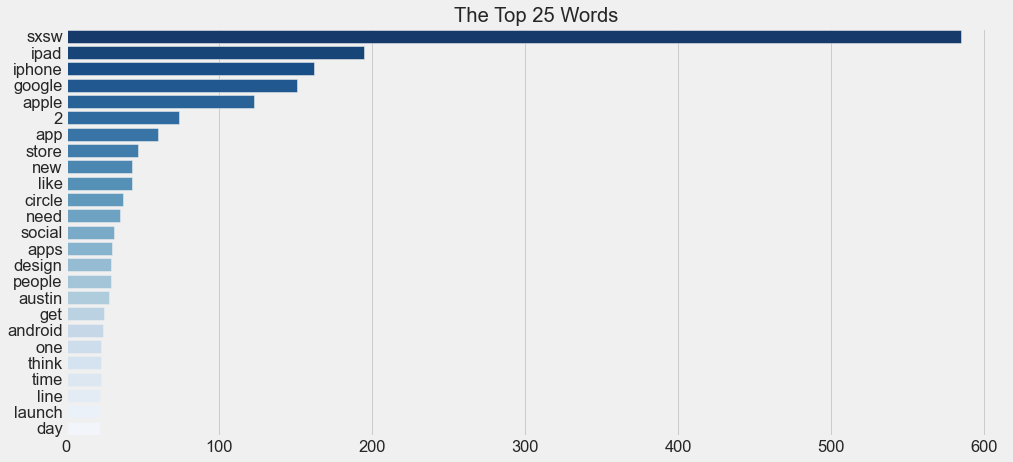

In [29]:
vz.top_word_list(neg_words, 25)

<font size="4">The top 25 words in the negative tweets follow as similar pattern as the words in the positive tweets but drop off even more rapidly.</font> 

## Word Clouds

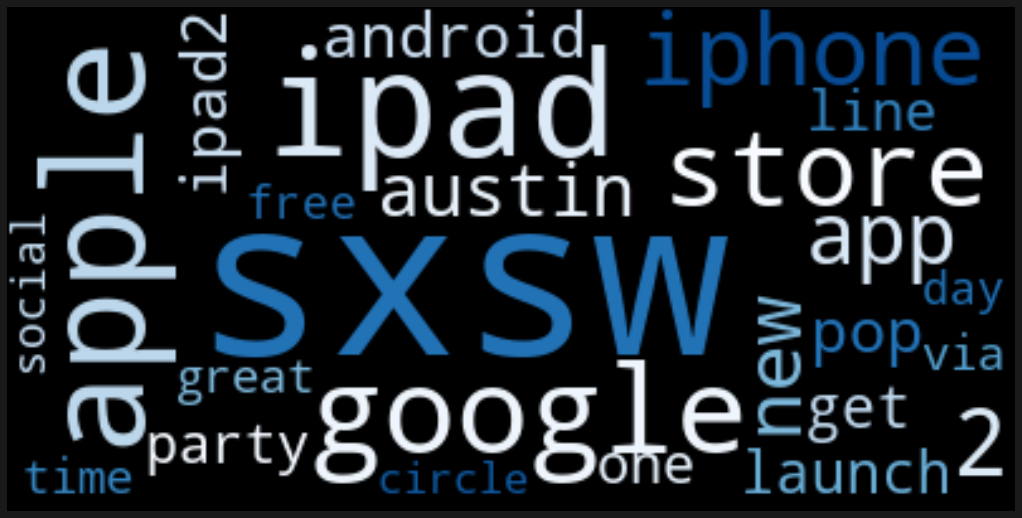

In [30]:
vz.word_cloud(pos_words, 25)

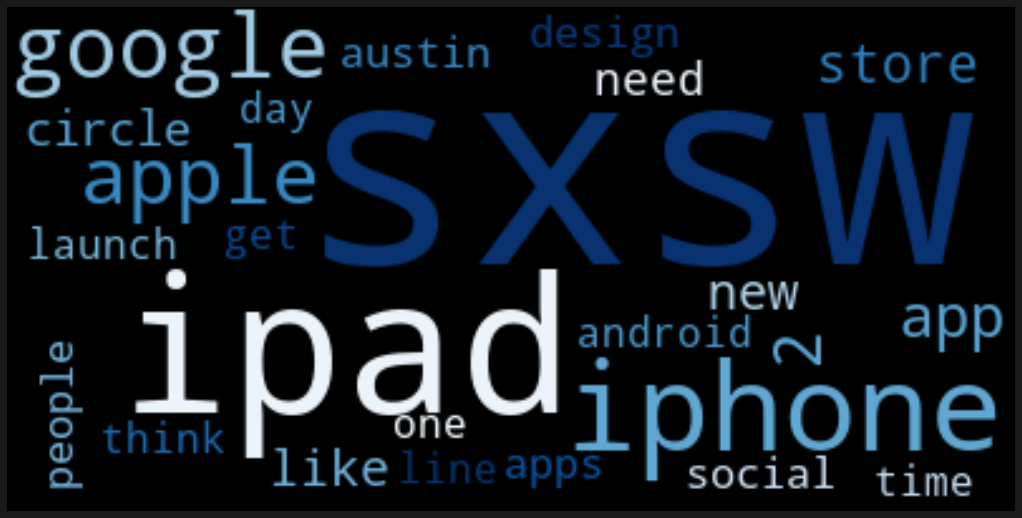

In [31]:
vz.word_cloud(neg_words, 25)

## Modeling Objects

In [32]:
# creating f1 scorer
f1 = fn.f1

# creating Harness
modeling = cl.Harness(f1)

# creating tfidf instance
tfidf = TfidfVectorizer(ngram_range=(1,1))

# creating oversampler instance
oversample = RandomOverSampler(sampling_strategy='minority', random_state=2021)

# creating SMOTE instance
sm = SMOTE(random_state=2021)

## Creating a Basline Classifier

In [33]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=2)

In [34]:
steps = [('tfidf', tfidf), ('clf', LR)]
baseline = Pipeline(steps=steps)

In [35]:
baseline.fit(X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [36]:
modeling.report(baseline, X_lem_train, y_lem_train, 'LR baseline', 'tfidf/no ngrams, no sampling')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


LR baseline has an average F1 of 0.915273690737922


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


array([0.91632373, 0.91632373, 0.91506849, 0.91632373, 0.91232877])

In [37]:
modeling.history

,Name,Accuracy (F1),Notes
0,LR baseline,0.915274,"tfidf/no ngrams, no sampling"


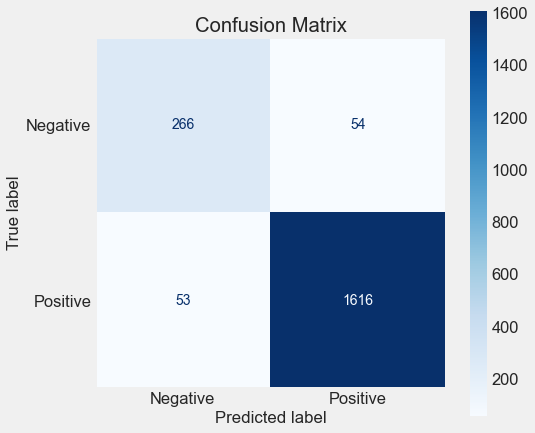

In [90]:
fn.confusion(baseline, X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


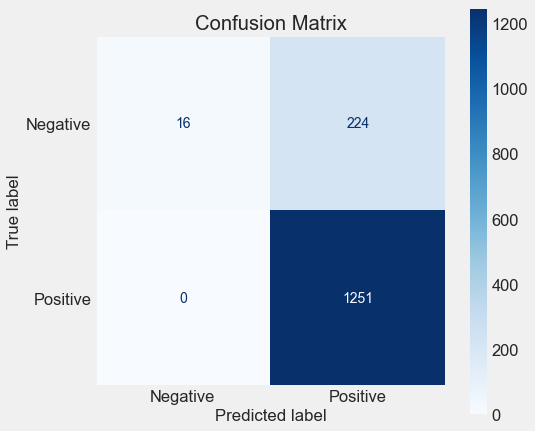

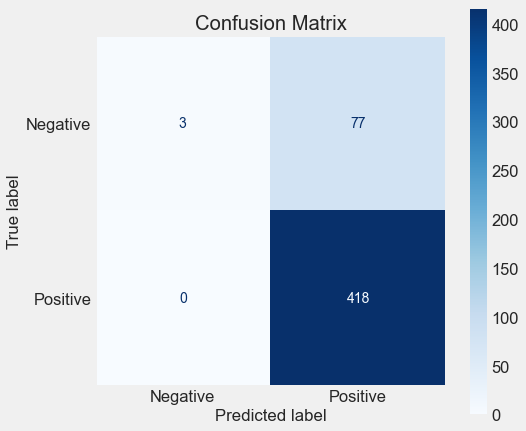

,Train F1,Test F1,Test Recall,Test Precision
0,0.917828,0.915663,1.0,0.844444


In [91]:
fn.subsplit_test(baseline, X_lem_train, y_lem_train)

## Baseline Minority Oversampling

In [92]:
df.emotion.value_counts(normalize=True)

1    0.839129
0    0.160871
Name: emotion, dtype: float64

In [93]:
steps = [('tfidf', tfidf), ('oversample', oversample), ('clf', LR)]
baseline_mo = Pipeline(steps=steps)

In [94]:
baseline_mo.fit(X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [95]:
modeling.report(baseline_mo, X_lem_train, y_lem_train, 'baseline_mo', 'minority oversampling')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


baseline_mo has an average F1 of 0.9085247087072126


array([0.90963855, 0.90332326, 0.90881913, 0.90881913, 0.91202346])

In [96]:
modeling.history

,Name,Accuracy (F1),Notes
0,multibayes,0.889805,minority oversamp
1,baseline_mo,0.908525,minority oversampling
7,baseline_mo,0.908525,minority oversampling
2,baseline smote,0.909462,smote
3,LR baseline,0.915274,"tfidf/no ngrams, no sampling"
4,tuned_baseline_mo,0.930467,"[('tfidf', TfidfVectorizer(ngram_range=(1, 2))..."
5,tuned_baseline_smote,0.930732,"[('tfidf', TfidfVectorizer(ngram_range=(1, 2))..."
6,tuned_baseline_smote,0.931778,"[('tfidf', TfidfVectorizer(ngram_range=(1, 2))..."


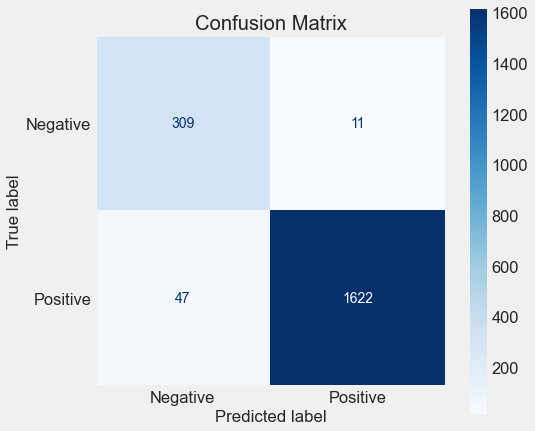

In [97]:
fn.confusion(baseline_mo, X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


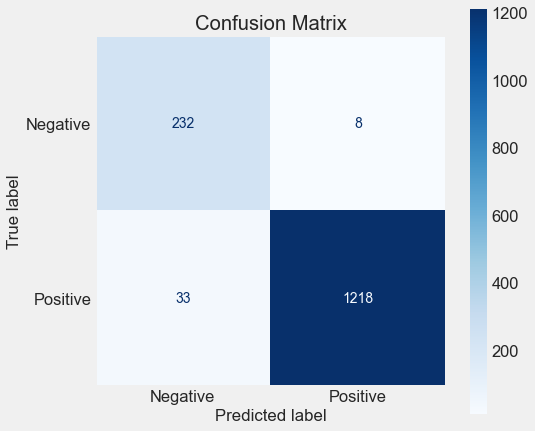

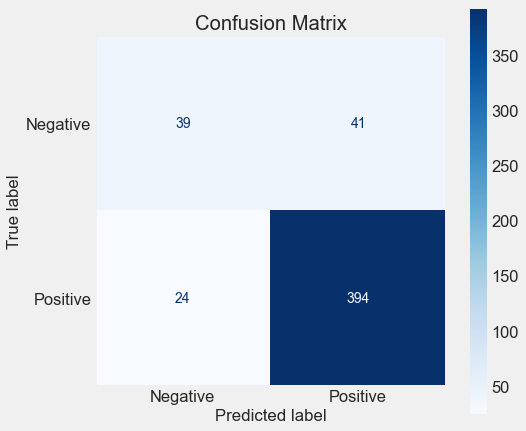

,Train F1,Test F1,Test Recall,Test Precision
0,0.983448,0.923798,0.942584,0.905747


In [98]:
fn.subsplit_test(baseline_mo, X_lem_train, y_lem_train)

## Baseline Minority Oversampling GridSearch

In [49]:
tfidf.get_params().keys()

dict_keys(['analyzer', 'binary', 'decode_error', 'dtype', 'encoding', 'input', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'norm', 'preprocessor', 'smooth_idf', 'stop_words', 'strip_accents', 'sublinear_tf', 'token_pattern', 'tokenizer', 'use_idf', 'vocabulary'])

In [50]:
LR.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [51]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-4, 2, 20),
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga', 'lbfgs']
    }

In [52]:
grid_clf_f1 = GridSearchCV(baseline_mo, param_grid = parameters,
                           n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
grid_clf_f1.fit(X_lem_train, y_lem_train)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed:  2.9min


[LibLinear]

[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  6.0min finished
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('oversample',
                                        RandomOverSampler(random_state=2021,
                                                          sampling_strategy='minority')),
                                       ('clf',
                                        LogisticRegression(max_iter=1000,
                                                           n_jobs=-1,
                                                           random_state=2021,
                                                           verbose=2))]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.00000000e-04, 2.06913808e-04, 4.28133240e-04, 8.85866790e-04,
       1.83298071e-03, 3....7674e-02,
       3.35981829e-02, 6.95192796e-02, 1.43844989e-01, 2.97635144e-01,
       6.15848211e-01, 1.27427499e+00, 2.63665090e+00, 5.45559478e+00,
       1.12883789e+01, 2.33572147e+01,

In [53]:
print('Best ngram_range:', grid_clf_f1.best_estimator_.get_params()['tfidf__ngram_range'])
print('Best use_idf:', grid_clf_f1.best_estimator_.get_params()['tfidf__use_idf'])
print('Best C:', grid_clf_f1.best_estimator_.get_params()['clf__C'])
print('Best penalty:', grid_clf_f1.best_estimator_.get_params()['clf__penalty'])
print('Best solver:', grid_clf_f1.best_estimator_.get_params()['clf__solver'])

Best ngram_range: (1, 2)
Best use_idf: True
Best C: 100.0
Best penalty: l2
Best solver: liblinear


In [54]:
steps = grid_clf_f1.best_estimator_.get_params()['steps']
tuned_baseline_mo = Pipeline(steps=steps)

In [55]:
modeling.report(tuned_baseline_mo, X_lem_train, y_lem_train, 'tuned_baseline_mo', f'{steps}')

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]tuned_baseline_mo has an average F1 of 0.9304667736668458


/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


array([0.93982808, 0.92857143, 0.93295292, 0.92877493, 0.92220651])

In [56]:
modeling.history

,Name,Accuracy (F1),Notes
0,baseline_mo,0.908525,minority oversampling
1,LR baseline,0.915274,"tfidf/no ngrams, no sampling"
2,tuned_baseline_mo,0.930467,"[('tfidf', TfidfVectorizer(ngram_range=(1, 2))..."


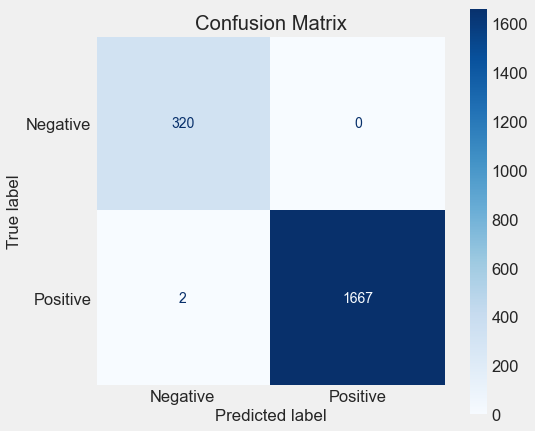

In [57]:
fn.confusion(tuned_baseline_mo, X_lem_train, y_lem_train)

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear]

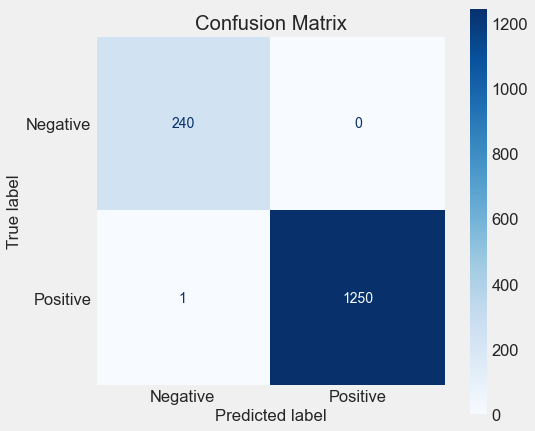

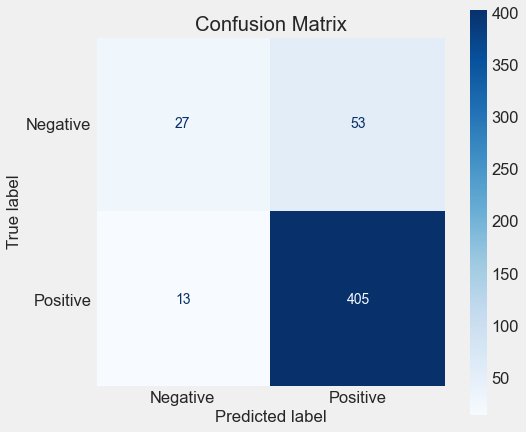

,Train F1,Test F1,Test Recall,Test Precision
0,0.9996,0.924658,0.9689,0.884279


In [58]:
fn.subsplit_test(tuned_baseline_mo, X_lem_train, y_lem_train)

## Baseline SMOTE 

In [59]:
steps = [('tfidf', tfidf), ('oversample', sm), ('clf', LR)]
baseline_smote = Pipeline(steps=steps)

In [60]:
baseline_smote.fit(X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample', SMOTE(random_state=2021)),
                ('clf',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=2021,
                                    verbose=2))])

In [61]:
modeling.report(baseline_smote, X_lem_train, y_lem_train, 'baseline smote', 'smote')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


baseline smote has an average F1 of 0.9094622974571168


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


array([0.91259259, 0.91154423, 0.9063893 , 0.9047619 , 0.91202346])

In [62]:
modeling.history

,Name,Accuracy (F1),Notes
0,baseline_mo,0.908525,minority oversampling
3,baseline smote,0.909462,smote
1,LR baseline,0.915274,"tfidf/no ngrams, no sampling"
2,tuned_baseline_mo,0.930467,"[('tfidf', TfidfVectorizer(ngram_range=(1, 2))..."


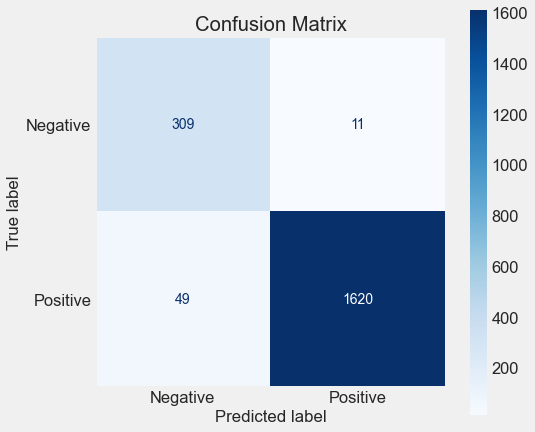

In [63]:
fn.confusion(baseline_smote, X_lem_train, y_lem_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


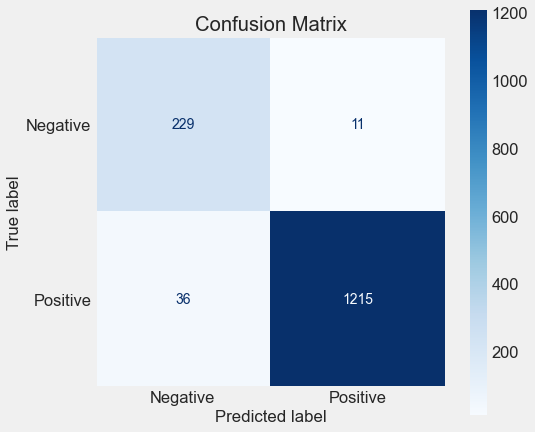

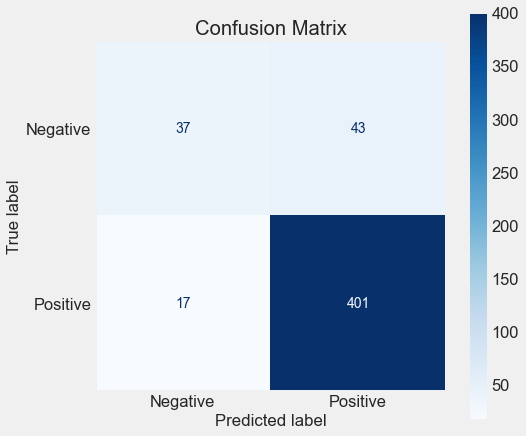

,Train F1,Test F1,Test Recall,Test Precision
0,0.981025,0.930394,0.95933,0.903153


In [64]:
fn.subsplit_test(baseline_smote, X_lem_train, y_lem_train)

## Baseline SMOTE GridSearch

In [65]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-4, 2, 20),
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga', 'lbfgs']
    }


In [66]:
grid_clf = GridSearchCV(baseline_smote, param_grid = parameters,
                           n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
grid_clf.fit(X_lem_train, y_lem_train)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 1085 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1354 tasks      | elapsed:  4.0min


[LibLinear]

[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  5.2min finished
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('oversample', SMOTE(random_state=2021)),
                                       ('clf',
                                        LogisticRegression(max_iter=1000,
                                                           n_jobs=-1,
                                                           random_state=2021,
                                                           verbose=2))]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.00000000e-04, 2.06913808e-04, 4.28133240e-04, 8.85866790e-04,
       1.83298071e-03, 3.79269019e-03, 7.84759970e-03, 1.62377674e-02,
       3.35981829e-02, 6.95192796e-02, 1.43844989e-01, 2.97635144e-01,
       6.15848211e-01, 1.27427499e+00, 2.63665090e+00, 5.45559478e+00,
       1.12883789e+01, 2.33572147e+01, 4.83293024e+01, 1.00000000e+02]),
                         'clf__penalty': ['l1', 'l2'],
                 

In [67]:
print('Best ngram_range:', grid_clf.best_estimator_.get_params()['tfidf__ngram_range'])
print('Best use_idf:', grid_clf.best_estimator_.get_params()['tfidf__use_idf'])
print('Best C:', grid_clf.best_estimator_.get_params()['clf__C'])
print('Best penalty:', grid_clf.best_estimator_.get_params()['clf__penalty'])
print('Best solver:', grid_clf.best_estimator_.get_params()['clf__solver'])

Best ngram_range: (1, 2)
Best use_idf: True
Best C: 100.0
Best penalty: l2
Best solver: liblinear


In [68]:
steps = grid_clf.best_estimator_.get_params()['steps']
tuned_baseline_smote = Pipeline(steps=steps)

In [69]:
modeling.report(tuned_baseline_smote,X_lem_train, y_lem_train, 'tuned_baseline_smote', f'{steps}')

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear][LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear][LibLinear][LibLinear]tuned_baseline_smote has an average F1 of 0.9307321653890526


/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


array([0.93982808, 0.92857143, 0.93428571, 0.92724679, 0.92372881])

In [70]:
modeling.history

,Name,Accuracy (F1),Notes
0,baseline_mo,0.908525,minority oversampling
1,baseline smote,0.909462,smote
2,LR baseline,0.915274,"tfidf/no ngrams, no sampling"
3,tuned_baseline_mo,0.930467,"[('tfidf', TfidfVectorizer(ngram_range=(1, 2))..."
4,tuned_baseline_smote,0.930732,"[('tfidf', TfidfVectorizer(ngram_range=(1, 2))..."


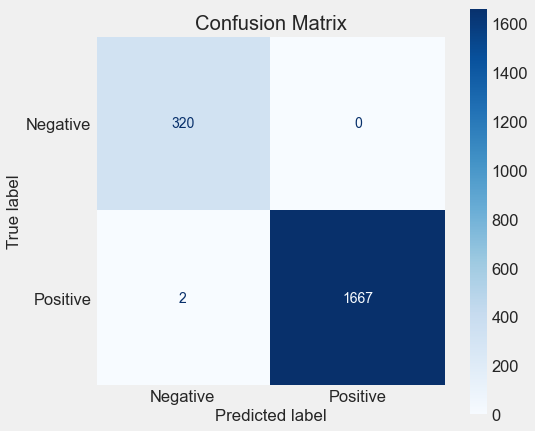

In [71]:
fn.confusion(tuned_baseline_smote, X_lem_train, y_lem_train)

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear]

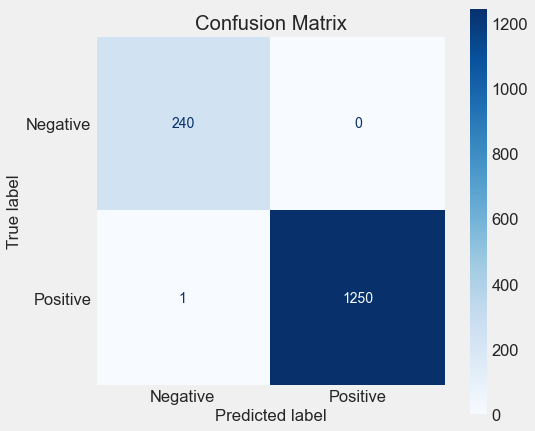

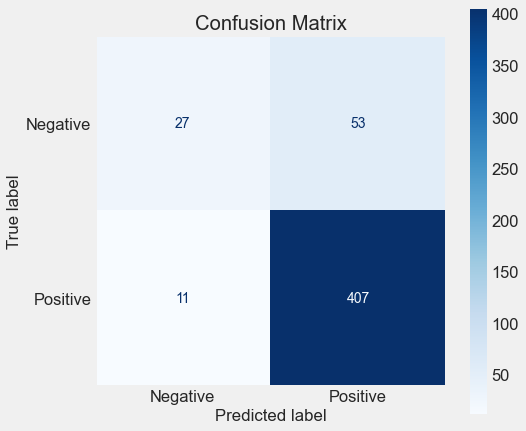

,Train F1,Test F1,Test Recall,Test Precision
0,0.9996,0.927107,0.973684,0.884783


In [72]:
fn.subsplit_test(tuned_baseline_smote, X_lem_train, y_lem_train)

## Naive Bayes

In [73]:
bayes = MultinomialNB()
steps = [('tfidf', tfidf), ('oversample', oversample), ('clf', bayes)]
mnb = Pipeline(steps=steps)
mnb.fit(X_lem_train, y_lem_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('oversample',
                 RandomOverSampler(random_state=2021,
                                   sampling_strategy='minority')),
                ('clf', MultinomialNB())])

In [74]:
modeling.report(mnb, X_lem_train, y_lem_train, 'multibayes', 'minority oversamp')

multibayes has an average F1 of 0.8898048726661459


array([0.87658228, 0.89433384, 0.88819876, 0.89127106, 0.89863843])

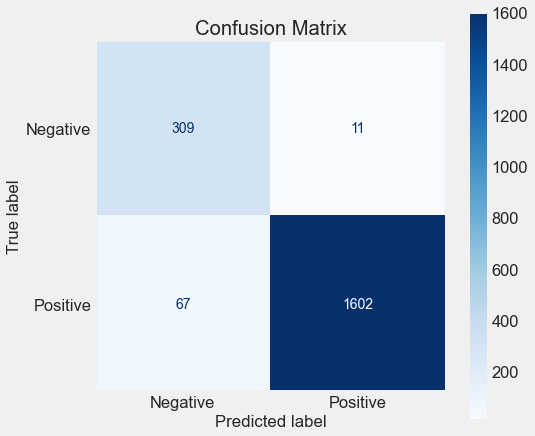

In [75]:
fn.confusion(mnb, X_lem_train, y_lem_train)

In [76]:
modeling.history

,Name,Accuracy (F1),Notes
5,multibayes,0.889805,minority oversamp
0,baseline_mo,0.908525,minority oversampling
1,baseline smote,0.909462,smote
2,LR baseline,0.915274,"tfidf/no ngrams, no sampling"
3,tuned_baseline_mo,0.930467,"[('tfidf', TfidfVectorizer(ngram_range=(1, 2))..."
4,tuned_baseline_smote,0.930732,"[('tfidf', TfidfVectorizer(ngram_range=(1, 2))..."


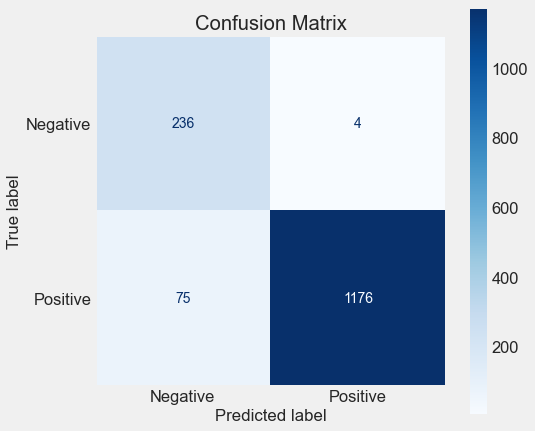

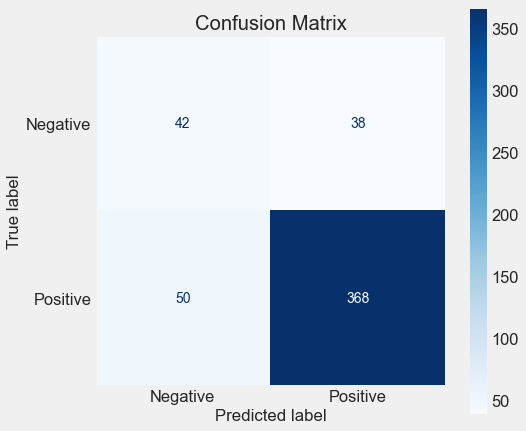

,Train F1,Test F1,Test Recall,Test Precision
0,0.967503,0.893204,0.880383,0.906404


In [77]:
fn.subsplit_test(mnb, X_lem_train, y_lem_train)

In [78]:
bayes.get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

## Tuned Naive Bayes

In [79]:
parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': [0, 25, .5, .75, 1],
    'clf__class_prior': [None, [.16, .84]],
    'clf__fit_prior': [True, False]
    }


In [80]:
grid_clf = GridSearchCV(mnb, param_grid = parameters,
                           n_jobs=-1, scoring = 'f1', cv=3, verbose=4)
grid_clf.fit(X_lem_train, y_lem_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    5.6s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('oversample',
                                        RandomOverSampler(random_state=2021,
                                                          sampling_strategy='minority')),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0, 25, 0.5, 0.75, 1],
                         'clf__class_prior': [None, [0.16, 0.84]],
                         'clf__fit_prior': [True, False],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__use_idf': (True, False)},
             scoring='f1', verbose=4)

In [81]:
print('Best ngram_range:', grid_clf.best_estimator_.get_params()['tfidf__ngram_range'])
print('Best use_idf:', grid_clf.best_estimator_.get_params()['tfidf__use_idf'])
print('Best clf__alpha:', grid_clf.best_estimator_.get_params()['clf__alpha'])
print('Best clf__class_prior:', grid_clf.best_estimator_.get_params()['clf__class_prior'])
print('Best clf__fit_prior:', grid_clf.best_estimator_.get_params()['clf__fit_prior'])

Best ngram_range: (1, 2)
Best use_idf: True
Best clf__alpha: 0.5
Best clf__class_prior: [0.16, 0.84]
Best clf__fit_prior: True


In [82]:
steps = grid_clf.best_estimator_.get_params()['steps']
tuned_bayes = Pipeline(steps=steps)

In [83]:
modeling.report(tuned_bayes ,X_lem_train, y_lem_train, 'tuned_baseline_smote', f'{steps}')

tuned_baseline_smote has an average F1 of 0.9317775011534593


array([0.93785311, 0.92977528, 0.93521127, 0.92847125, 0.9275766 ])

In [84]:
modeling.history

,Name,Accuracy (F1),Notes
0,multibayes,0.889805,minority oversamp
1,baseline_mo,0.908525,minority oversampling
2,baseline smote,0.909462,smote
3,LR baseline,0.915274,"tfidf/no ngrams, no sampling"
4,tuned_baseline_mo,0.930467,"[('tfidf', TfidfVectorizer(ngram_range=(1, 2))..."
5,tuned_baseline_smote,0.930732,"[('tfidf', TfidfVectorizer(ngram_range=(1, 2))..."
6,tuned_baseline_smote,0.931778,"[('tfidf', TfidfVectorizer(ngram_range=(1, 2))..."


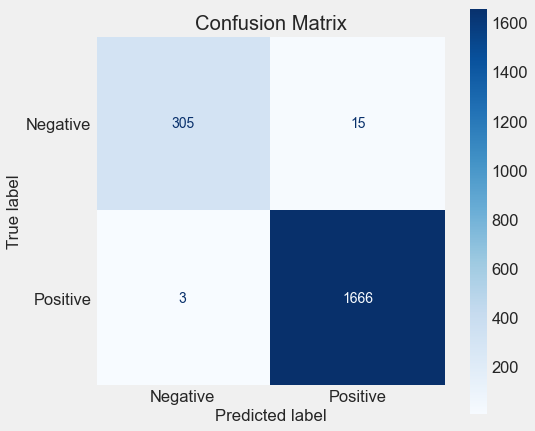

In [85]:
fn.confusion(tuned_bayes, X_lem_train, y_lem_train)

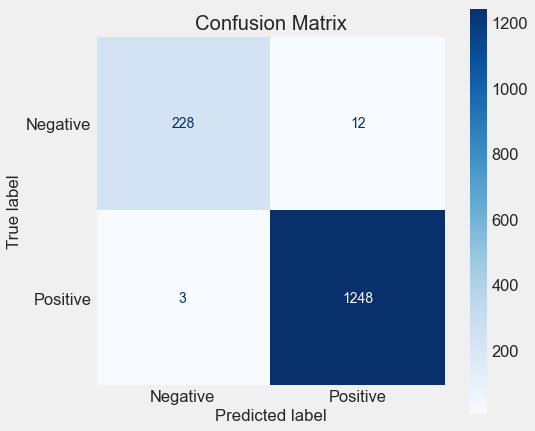

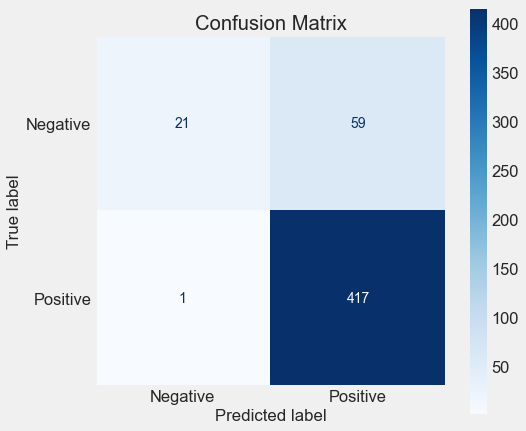

,Train F1,Test F1,Test Recall,Test Precision
0,0.994026,0.932886,0.997608,0.87605


In [86]:
fn.subsplit_test(tuned_bayes, X_lem_train, y_lem_train)

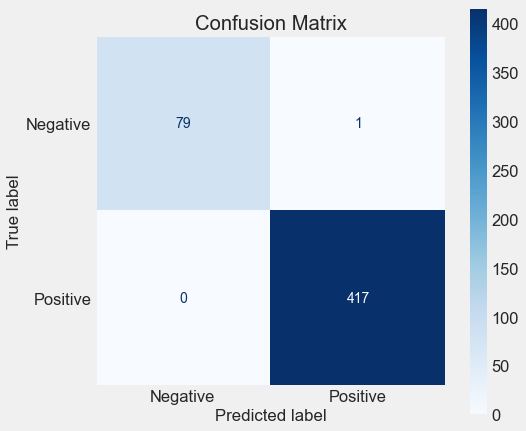

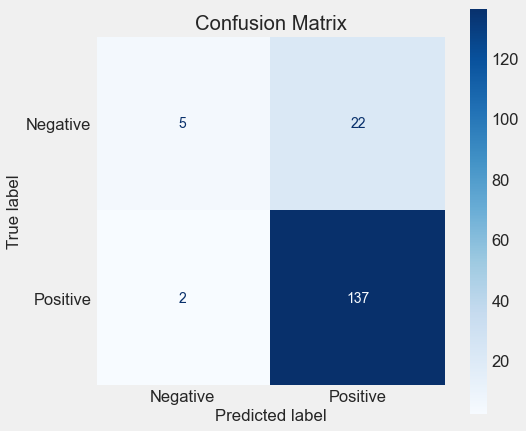

,Train F1,Test F1,Test Recall,Test Precision
0,0.998802,0.919463,0.985612,0.861635


In [89]:
fn.subsplit_test(tuned_bayes, X_lem_val, y_lem_val)